# Clasificación de rótulos de tránsito (EEUU) utilizando la arquitectura de CNN Le_Net  

# Enunciado del problema

A lo largo del tiempo, se han desarrollado muchas arquitecturas de redes neuronales, algunas de ellas se han vuelto clásicas.  Una de ellas es una CNN (red neuronal convolucional) desarrollada por Yann LeCun a la que le denominó Le-Net.  Pueden ver el artículo original en:

http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf

El diseño es el siguiente:

![Arquitectura Le-Net](../Images/Le-Net.png)

* C: Capa de Convolución, 
* S: Capa de Submuestreo (Pooling), 
* F: Capa completamente conectada (Fully Connected)

En este caso de estudio, se proveen imágenes de rótulos de tráfico y el objetivo es entrenar una red Le-Net para que las pueda clasificar

- El conjunto de datos contiene 43 clases diferentes de imágenes. 
- Las clases se listan abajo: 

    0 - Limite velocidad (20km/h)  
    1 - Limite velocidad (30km/h)  
    2 - Limite velocidad (50km/h)  
    3 - Limite velocidad (60km/h)  
    4 - Limite velocidad (70km/h)  
    5 - Limite velocidad (80km/h)  
    6 - Fin de limite velocidad (80km/h)'  
    7 - Limite velocidad (100km/h)  
    8 - Limite velocidad (120km/h)  
    9 - No rebasar  
    10 - No rebasar para vehiculos mayores de 3.5 tonladas metricas  
    11 - Derecho-de-via en la siguiente interseccion  
    12 - Camino prioritario  
    13 - Ceda el paso  
    14 - Alto  
    15 - No vehiculos  
    16 - Prohibido vehiculos mayores de 3.5 toneladas metricas  
    17 - No hay entrada
    18 - Precaucion general  
    19 - Curva peligrosa a la izquierda  
    20 - Curva peligrosa a la derecha  
    21 - Doble curva  
    22 - Camino disparejo  
    23 - Camino resbaloso  
    24 - Camino se reduce a la derecha  
    25 - Trabajos adelante  
    26 - Señales de Trafico -semaforos-  
    27 - Cruce de peatones  
    28 - Cruce de Niños  
    29 - Cruce de bicicletas  
    30 - Cuidado hielo/nieve  
    31 - Cruce de animales silvestres  
    32 - Fin de todos los limites de velocidad y rebase  
    33 - Gire a la derecha adelante  
    34 - Gire a la izquierda adelante  
    35 - Recto solo  
    36 - Vaya recto o a la rerecha  
    37 - Vaya recto o a la izquierda  
    38 - Mantengase a la derecha  
    39 - Mantengase a la izquierda  
    40 - Vuelta en U obligada  
    41 - Fin de no rebasar  
    42 - Fin de no rebasar para vehiculos mayores de 3.5 toneladas metricas




Referencias (Señales de Tráfico)

J. Stallkamp, M. Schlipsing, J. Salmen, and C. Igel. The German Traffic Sign Recognition Benchmark: A multi-class classification competition. In Proceedings of the IEEE International Joint Conference on Neural Networks, pages 1453–1460. 2011. 

@inproceedings{Stallkamp-IJCNN-2011,
    author = {Johannes Stallkamp and Marc Schlipsing and Jan Salmen and Christian Igel},
    booktitle = {IEEE International Joint Conference on Neural Networks},
    title = {The {G}erman {T}raffic {S}ign {R}ecognition {B}enchmark: A multi-class classification competition},
    year = {2011},
    pages = {1453--1460}
}



# IMPORTAR LIBRERIAS

In [106]:
import warnings
warnings.filterwarnings("ignore")

In [107]:
import pickle
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow import keras

# Obtener Datos

El módulo de Pickle implementa protocolos binarios para la serialización y de-serialización de objetos Python

In [108]:
with open("entrenamiento.p", mode='rb') as datos_entreno:
    entreno = pickle.load(datos_entreno)
with open("validacion.p", mode='rb') as datos_validacion:
    valida = pickle.load(datos_validacion)
with open("prueba.p", mode='rb') as datos_prueba:
    prueba = pickle.load(datos_prueba)

In [109]:
X_entreno, y_entreno = entreno['features'], entreno['labels']
X_valida, y_valida = valida['features'], valida['labels']
X_prueba, y_prueba = prueba['features'], prueba['labels']


In [110]:
X_entreno.shape

(34799, 32, 32, 3)

In [111]:
y_entreno.shape

(34799,)

# EXPLORACION DE LAS IMAGENES

Mostrar que las imágenes no están "barajeadas"

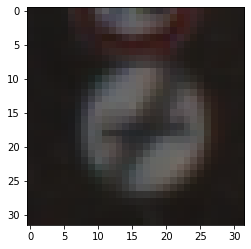

In [112]:
imagen = X_entreno[0]
plt.imshow(imagen)
# Podemos ver que las imagenes no estan en orden ya que la primera no pertenece a limite de velocidad de 20

# PREPARACION DE LOS DATOS

In [113]:
from sklearn.utils import shuffle
# "Barajear" los datos
X_entreno, y_entreno = shuffle(X_entreno, y_entreno)

In [114]:
# Convertir imágenes a blanco y negro
X_entreno_gray = np.sum(X_entreno/3, axis=3, keepdims=True)
X_prueba_gray  = np.sum(X_prueba/3, axis=3, keepdims=True)
X_valida_gray  = np.sum(X_valida/3, axis=3, keepdims=True) 

In [115]:
# Normalizar los datos
X_entreno_norm_gray = (X_entreno_gray - 128)/128 
X_prueba_norm_gray = (X_prueba_gray - 128)/128
X_valida_norm_gray  = (X_valida_gray - 128)/128


# Entrenamiento del modelo

El modelo consiste de las siguientes capas: 

- Paso 1: La primera capa convolucional #1

    - Entrada = 32x32x1
    - Salida = 28x28x6
    - Salida = (Entrada-filtro+1)/Paso* => (32-5+1)/1=28
    - Se utiliza un filtro de 5x5 con una profundidad de entrada 3 y profundidad de salida 6
    - Aplicar una función de activación RELU a la salida
    - Submuestreo (pooling) para la entrada, Entrada = 28x28x6 y Salida = 14x14x6


    * Paso (Stride) es la cantidad por la cual el kernel se desplaza cuando el kernel se pasa sobre la imagen.

- Paso 2: La segunda capa covolucional #2

    - Entrada = 14x14x6
    - Salida = 10x10x16
    - Capa 2: Capa convolutional con salida = 10x10x16
    - Output = (Input-filter+1)/strides => 10 = 14-5+1/1
    - Aplicar una función de activación RELU a la salida
    - Submuestreo (pooling) con Entrada = 10x10x16 Salida = 5x5x16

- Paso 3: "Aplanar" la red (convertir a una dimensión)

    - Entrada = 5x5x16 y Salida = 400

- Paso 4: Capa plenamenente conectada

    - Capa 3: Capa plenamente conectada con Entrada = 400 y Salida = 120
    - Aplicar una función de activación RELU a la salida

- Paso 5: Otra capa plenamente conectada

    - Capa 4: Capa plenamente conectada con Entrada = 120 y Salida = 84
    - Aplicar una función de activación RELU a la salida

- Paso 6: Otra capa plenamente conectada

    - Capa 5: Capa plenamente conectada con Entrada = 84 y Salida = 43

# Importar librerías para construir el modelo

In [116]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

In [117]:
# Crear el modelo
cnn_model = Sequential()
cnn_model.add(Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(32,32,1)))
cnn_model.add(AveragePooling2D())
cnn_model.add(Conv2D(filters=16, kernel_size=(5, 5), activation='relu'))
cnn_model.add(AveragePooling2D())
cnn_model.add(Flatten())
cnn_model.add(Dense(units=120, activation='relu'))
cnn_model.add(Dense(units=84, activation='relu'))
cnn_model.add(Dense(units=43, activation = 'softmax'))

In [118]:
# Compilar el modelo
cnn_model.compile(loss ='sparse_categorical_crossentropy', optimizer=Adam(lr=0.001),metrics =['accuracy'])

In [119]:
# Entrenar el modelo y guardar los datos en un hhistorial
resultados = cnn_model.fit(X_entreno_norm_gray, y_entreno,epochs = 10,
                                  verbose=1,
                                  batch_size=500,
                                  validation_data = (X_valida_norm_gray, y_valida),)
perdidas = pd.DataFrame(cnn_model.history.history)

Epoch 1/10
70/70 [==============================] - 4s 55ms/step - loss: 3.2935 - accuracy: 0.1353 - val_loss: 2.9930 - val_accuracy: 0.2193
Epoch 2/10
70/70 [==============================] - 4s 53ms/step - loss: 1.9591 - accuracy: 0.4711 - val_loss: 1.6375 - val_accuracy: 0.5440
Epoch 3/10
70/70 [==============================] - 4s 59ms/step - loss: 1.0630 - accuracy: 0.6960 - val_loss: 1.0990 - val_accuracy: 0.6873
Epoch 4/10
70/70 [==============================] - 4s 58ms/step - loss: 0.7438 - accuracy: 0.7892 - val_loss: 0.8443 - val_accuracy: 0.7626
Epoch 5/10
70/70 [==============================] - 4s 56ms/step - loss: 0.5832 - accuracy: 0.8370 - val_loss: 0.7603 - val_accuracy: 0.7841
Epoch 6/10
70/70 [==============================] - 4s 58ms/step - loss: 0.4763 - accuracy: 0.8676 - val_loss: 0.7046 - val_accuracy: 0.8098
Epoch 7/10
70/70 [==============================] - 4s 61ms/step - loss: 0.4117 - accuracy: 0.8861 - val_loss: 0.7036 - val_accuracy: 0.8068
Epoch 8/10
70

# EVALUACION DEL MODELO

In [120]:
# Evaluar el modelo e indicar la exactitud con los datos de prueba
test_loss, test_acc = cnn_model.evaluate(X_prueba_norm_gray,  y_prueba, verbose=2)

print('\nTest accuracy:', test_acc)

395/395 - 1s - loss: 0.9376 - accuracy: 0.8062 - 786ms/epoch - 2ms/step

Test accuracy: 0.8061757683753967


In [121]:
print(cnn_model.metrics_names)
print(cnn_model.evaluate(X_prueba_norm_gray, y_prueba, verbose = 0))

['loss', 'accuracy']
[0.9375692009925842, 0.8061757683753967]


<AxesSubplot:>

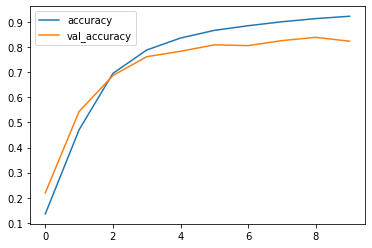

In [122]:
# Generar gráfica de Exactitud y de Entrenamiento y Validación
perdidas[['accuracy', 'val_accuracy']].plot()


<AxesSubplot:>

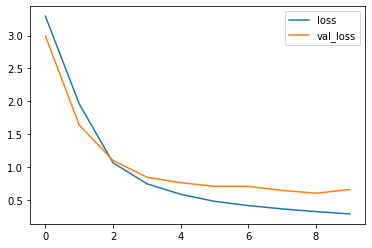

In [123]:
# Generar gráfica de Pérdida de Entrenamiento y Validación
perdidas[['loss', 'val_loss']].plot()

# Obtener las predicciones para los datos de prueba

395/395 [==============================] - 1s 2ms/step


<AxesSubplot:>

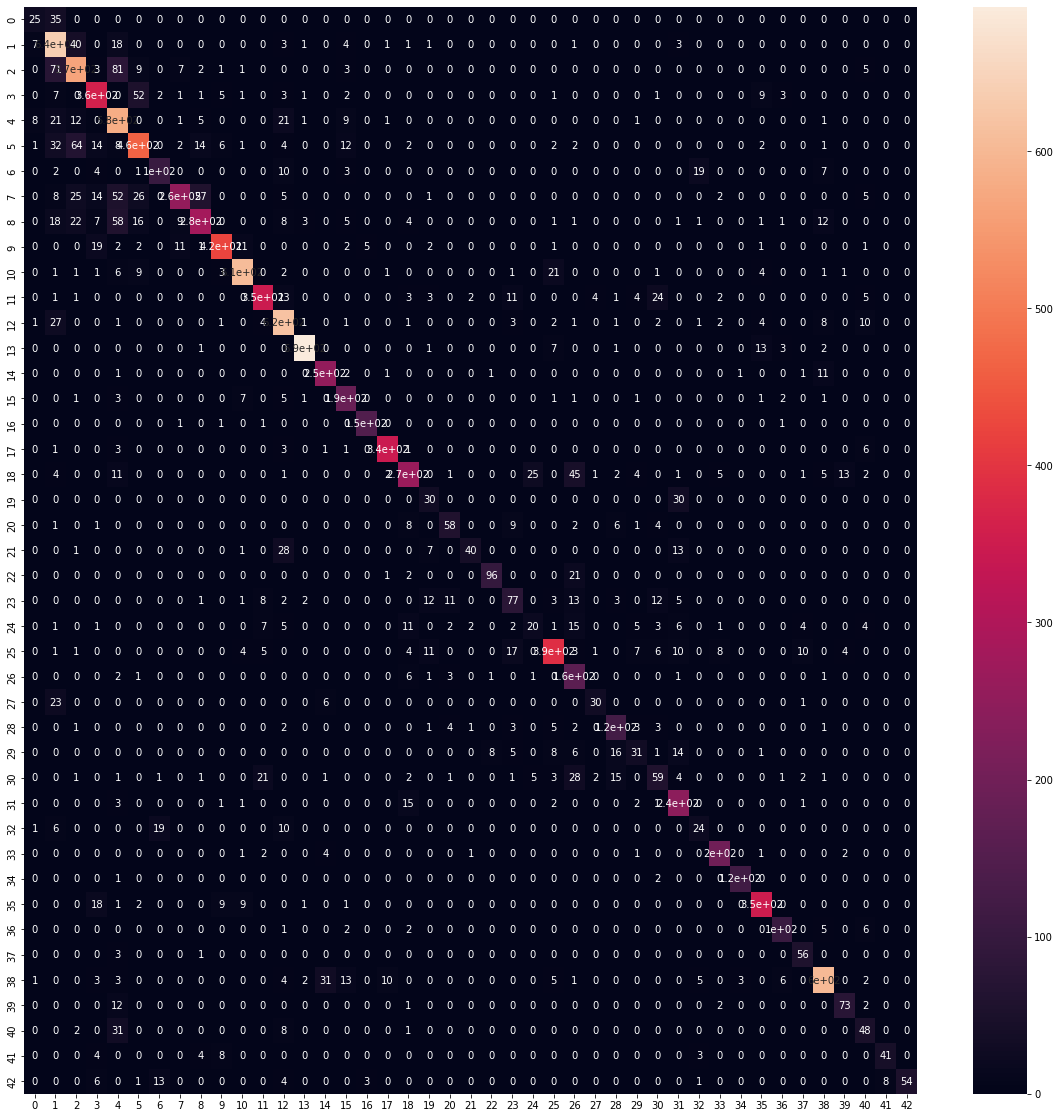

In [124]:
#  A partir de la versión 2.6 de tensorflow, la siguiente instrucción
#    puede dar el error:  ‘Sequential’ object has no attribute ‘predict_classes’
#    por lo que se sustituye por la que le sigue
#
#clases_predichas = modelo_cnn.predict_classes(X_prueba_gris_norm)

class_predic = np.argmax(cnn_model.predict(X_prueba_norm_gray),axis=1)

# se obtienen los índices para poder graficar
# Generar un mapa de calor para la matriz de confusión

class_predic = np.argmax(cnn_model.predict(X_prueba_norm_gray),axis=1)
from sklearn.metrics import confusion_matrix
matriz = confusion_matrix(y_prueba, class_predic)
plt.figure(figsize = (20,20))
sns.heatmap(matriz, annot=True)

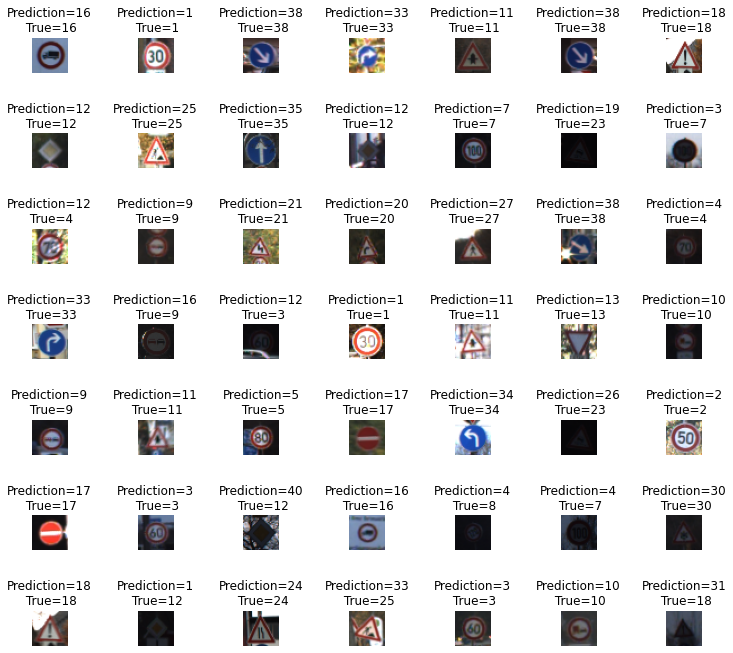

In [125]:
fig, axes = plt.subplots(7, 7, figsize = (12,12))
axes = axes.ravel()               

for i in np.arange(0, 7 * 7):
    axes[i].axis('off')            
    axes[i].imshow(X_prueba[i])
    axes[i].set_title("Prediction={}\n True={}".format(class_predic[i], y_prueba[i]))

plt.subplots_adjust(wspace=2)  

#  Ajustes del modelo

Como se puede ver, hay muchos lugares donde se puede cambiar la configuración del modelo.  A continuación se sugieren varias posibilidades que deben probar e indicar si se mejora la exactitud del modelo:

1. Incrementar el número de épocas para el entrenamiento a 500 ó 1,000
2. En las capas de convolución cambiar el tamaño del kernel a 10 X 10
3. Cambiar el método de submuestrear (pooling) a MaxPooling
4. Cambiar el numero de la segunda capa plenamente conectada de 84 a 100 unidades
5. Cambiar el número de la primera capa plenamente conectada de 120 a 300 unidades

La idea es ir haciendo los cambios uno por uno y ver cómo va cambiando la exactitud del modelo

In [126]:
# Crear el modelo
cnn_model = Sequential()
cnn_model.add(Conv2D(filters=6, kernel_size=(10, 10), activation='relu', input_shape=(32,32,1)))
cnn_model.add(AveragePooling2D())
cnn_model.add(Conv2D(filters=16, kernel_size=(10, 10), activation='relu'))
cnn_model.add(AveragePooling2D())
cnn_model.add(Flatten())
cnn_model.add(Dense(units=120, activation='relu'))
cnn_model.add(Dense(units=84, activation='relu'))
cnn_model.add(Dense(units=43, activation = 'softmax'))
cnn_model.compile(loss ='sparse_categorical_crossentropy', optimizer=Adam(lr=0.001),metrics =['accuracy'])
# Entrenar el modelo y guardar los datos en un hhistorial
resultados = cnn_model.fit(X_entreno_norm_gray, y_entreno,epochs = 10,
                                  verbose=1,
                                  batch_size=500,
                                  validation_data = (X_valida_norm_gray, y_valida),)
perdidas = pd.DataFrame(cnn_model.history.history)
test_loss, test_acc = cnn_model.evaluate(X_prueba_norm_gray,  y_prueba, verbose=2)

print('\nTest accuracy:', test_acc)

Epoch 1/10
70/70 [==============================] - 3s 46ms/step - loss: 3.3964 - accuracy: 0.0987 - val_loss: 3.2549 - val_accuracy: 0.1891
Epoch 2/10
70/70 [==============================] - 3s 45ms/step - loss: 2.3563 - accuracy: 0.3447 - val_loss: 2.0731 - val_accuracy: 0.3776
Epoch 3/10
70/70 [==============================] - 3s 44ms/step - loss: 1.4609 - accuracy: 0.5676 - val_loss: 1.4214 - val_accuracy: 0.5805
Epoch 4/10
70/70 [==============================] - 3s 46ms/step - loss: 1.0577 - accuracy: 0.6844 - val_loss: 1.1135 - val_accuracy: 0.6737
Epoch 5/10
70/70 [==============================] - 3s 47ms/step - loss: 0.8471 - accuracy: 0.7479 - val_loss: 0.9156 - val_accuracy: 0.7270
Epoch 6/10
70/70 [==============================] - 3s 48ms/step - loss: 0.6971 - accuracy: 0.7992 - val_loss: 0.8009 - val_accuracy: 0.7719
Epoch 7/10
70/70 [==============================] - 3s 46ms/step - loss: 0.5972 - accuracy: 0.8322 - val_loss: 0.7296 - val_accuracy: 0.7909
Epoch 8/10
70

In [127]:
# Crear el modelo
cnn_model = Sequential()
cnn_model.add(Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(32,32,1)))
cnn_model.add(MaxPooling2D())
cnn_model.add(Conv2D(filters=16, kernel_size=(5, 5), activation='relu'))
cnn_model.add(MaxPooling2D())
cnn_model.add(Flatten())
cnn_model.add(Dense(units=120, activation='relu'))
cnn_model.add(Dense(units=84, activation='relu'))
cnn_model.add(Dense(units=43, activation = 'softmax'))
cnn_model.compile(loss ='sparse_categorical_crossentropy', optimizer=Adam(lr=0.001),metrics =['accuracy'])
# Entrenar el modelo y guardar los datos en un hhistorial
resultados = cnn_model.fit(X_entreno_norm_gray, y_entreno,epochs = 10,
                                  verbose=1,
                                  batch_size=500,
                                  validation_data = (X_valida_norm_gray, y_valida),)
perdidas = pd.DataFrame(cnn_model.history.history)
test_loss, test_acc = cnn_model.evaluate(X_prueba_norm_gray,  y_prueba, verbose=2)

print('\nTest accuracy:', test_acc)

Epoch 1/10
70/70 [==============================] - 4s 53ms/step - loss: 3.0589 - accuracy: 0.2120 - val_loss: 2.5722 - val_accuracy: 0.3580
Epoch 2/10
70/70 [==============================] - 4s 55ms/step - loss: 1.5690 - accuracy: 0.5677 - val_loss: 1.4440 - val_accuracy: 0.5866
Epoch 3/10
70/70 [==============================] - 4s 52ms/step - loss: 0.8555 - accuracy: 0.7598 - val_loss: 0.9828 - val_accuracy: 0.7147
Epoch 4/10
70/70 [==============================] - 4s 55ms/step - loss: 0.5798 - accuracy: 0.8454 - val_loss: 0.7708 - val_accuracy: 0.7753
Epoch 5/10
70/70 [==============================] - 4s 53ms/step - loss: 0.4392 - accuracy: 0.8860 - val_loss: 0.6611 - val_accuracy: 0.8054
Epoch 6/10
70/70 [==============================] - 4s 53ms/step - loss: 0.3529 - accuracy: 0.9086 - val_loss: 0.6477 - val_accuracy: 0.8204
Epoch 7/10
70/70 [==============================] - 4s 51ms/step - loss: 0.2875 - accuracy: 0.9280 - val_loss: 0.5587 - val_accuracy: 0.8510
Epoch 8/10
70

In [128]:
# Crear el modelo
cnn_model = Sequential()
cnn_model.add(Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(32,32,1)))
cnn_model.add(AveragePooling2D())
cnn_model.add(Conv2D(filters=16, kernel_size=(5, 5), activation='relu'))
cnn_model.add(AveragePooling2D())
cnn_model.add(Flatten())
cnn_model.add(Dense(units=120, activation='relu'))
cnn_model.add(Dense(units=100, activation='relu'))
cnn_model.add(Dense(units=43, activation = 'softmax'))
cnn_model.compile(loss ='sparse_categorical_crossentropy', optimizer=Adam(lr=0.001),metrics =['accuracy'])
# Entrenar el modelo y guardar los datos en un hhistorial
resultados = cnn_model.fit(X_entreno_norm_gray, y_entreno,epochs = 10,
                                  verbose=1,
                                  batch_size=500,
                                  validation_data = (X_valida_norm_gray, y_valida),)
perdidas = pd.DataFrame(cnn_model.history.history)
test_loss, test_acc = cnn_model.evaluate(X_prueba_norm_gray,  y_prueba, verbose=2)

print('\nTest accuracy:', test_acc)

Epoch 1/10
70/70 [==============================] - 4s 50ms/step - loss: 3.2220 - accuracy: 0.1765 - val_loss: 2.8132 - val_accuracy: 0.3206
Epoch 2/10
70/70 [==============================] - 4s 50ms/step - loss: 1.7830 - accuracy: 0.5110 - val_loss: 1.4720 - val_accuracy: 0.5751
Epoch 3/10
70/70 [==============================] - 3s 49ms/step - loss: 1.0129 - accuracy: 0.7085 - val_loss: 1.0278 - val_accuracy: 0.6946
Epoch 4/10
70/70 [==============================] - 3s 49ms/step - loss: 0.6916 - accuracy: 0.8083 - val_loss: 0.7832 - val_accuracy: 0.7646
Epoch 5/10
70/70 [==============================] - 3s 48ms/step - loss: 0.5347 - accuracy: 0.8564 - val_loss: 0.7053 - val_accuracy: 0.7932
Epoch 6/10
70/70 [==============================] - 3s 48ms/step - loss: 0.4456 - accuracy: 0.8809 - val_loss: 0.6728 - val_accuracy: 0.7968
Epoch 7/10
70/70 [==============================] - 3s 49ms/step - loss: 0.3724 - accuracy: 0.9032 - val_loss: 0.6018 - val_accuracy: 0.8268
Epoch 8/10
70

In [129]:
# Crear el modelo
cnn_model = Sequential()
cnn_model.add(Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(32,32,1)))
cnn_model.add(AveragePooling2D())
cnn_model.add(Conv2D(filters=16, kernel_size=(5, 5), activation='relu'))
cnn_model.add(AveragePooling2D())
cnn_model.add(Flatten())
cnn_model.add(Dense(units=300, activation='relu'))
cnn_model.add(Dense(units=84, activation='relu'))
cnn_model.add(Dense(units=43, activation = 'softmax'))
cnn_model.compile(loss ='sparse_categorical_crossentropy', optimizer=Adam(lr=0.001),metrics =['accuracy'])
# Entrenar el modelo y guardar los datos en un hhistorial
resultados = cnn_model.fit(X_entreno_norm_gray, y_entreno,epochs = 10,
                                  verbose=1,
                                  batch_size=500,
                                  validation_data = (X_valida_norm_gray, y_valida),)
perdidas = pd.DataFrame(cnn_model.history.history)
test_loss, test_acc = cnn_model.evaluate(X_prueba_norm_gray,  y_prueba, verbose=2)

print('\nTest accuracy:', test_acc)

Epoch 1/10
70/70 [==============================] - 4s 53ms/step - loss: 3.0216 - accuracy: 0.2180 - val_loss: 2.4592 - val_accuracy: 0.3322
Epoch 2/10
70/70 [==============================] - 4s 53ms/step - loss: 1.4631 - accuracy: 0.5955 - val_loss: 1.3023 - val_accuracy: 0.6229
Epoch 3/10
70/70 [==============================] - 4s 53ms/step - loss: 0.8252 - accuracy: 0.7663 - val_loss: 0.9839 - val_accuracy: 0.6923
Epoch 4/10
70/70 [==============================] - 4s 52ms/step - loss: 0.5857 - accuracy: 0.8372 - val_loss: 0.7923 - val_accuracy: 0.7782
Epoch 5/10
70/70 [==============================] - 4s 51ms/step - loss: 0.4564 - accuracy: 0.8766 - val_loss: 0.7585 - val_accuracy: 0.7934
Epoch 6/10
70/70 [==============================] - 4s 53ms/step - loss: 0.3772 - accuracy: 0.8991 - val_loss: 0.6712 - val_accuracy: 0.8229
Epoch 7/10
70/70 [==============================] - 4s 54ms/step - loss: 0.3204 - accuracy: 0.9161 - val_loss: 0.6112 - val_accuracy: 0.8426
Epoch 8/10
70

EL MEJOR MODELO ENCONTRADO

In [130]:
# Crear el modelo
cnn_model = Sequential()
cnn_model.add(Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(32,32,1)))
cnn_model.add(MaxPooling2D())
cnn_model.add(Conv2D(filters=16, kernel_size=(5, 5), activation='relu'))
cnn_model.add(MaxPooling2D())
cnn_model.add(Flatten())
cnn_model.add(Dense(units=300, activation='relu'))
cnn_model.add(Dense(units=100, activation='relu'))
cnn_model.add(Dense(units=43, activation = 'softmax'))
cnn_model.compile(loss ='sparse_categorical_crossentropy', optimizer=Adam(lr=0.001),metrics =['accuracy'])
# Entrenar el modelo y guardar los datos en un hhistorial
resultados = cnn_model.fit(X_entreno_norm_gray, y_entreno,epochs = 25,
                                  verbose=1,
                                  batch_size=500,
                                  validation_data = (X_valida_norm_gray, y_valida),)
perdidas = pd.DataFrame(cnn_model.history.history)
test_loss, test_acc = cnn_model.evaluate(X_prueba_norm_gray,  y_prueba, verbose=2)

print('\nTest accuracy:', test_acc)

Epoch 1/25
70/70 [==============================] - 4s 57ms/step - loss: 2.8950 - accuracy: 0.2534 - val_loss: 1.9923 - val_accuracy: 0.4696
Epoch 2/25
70/70 [==============================] - 4s 56ms/step - loss: 1.1303 - accuracy: 0.6884 - val_loss: 1.0024 - val_accuracy: 0.7293
Epoch 3/25
70/70 [==============================] - 4s 64ms/step - loss: 0.6000 - accuracy: 0.8401 - val_loss: 0.7596 - val_accuracy: 0.7875
Epoch 4/25
70/70 [==============================] - 4s 62ms/step - loss: 0.4017 - accuracy: 0.8989 - val_loss: 0.6628 - val_accuracy: 0.8281
Epoch 5/25
70/70 [==============================] - 4s 58ms/step - loss: 0.2875 - accuracy: 0.9293 - val_loss: 0.6273 - val_accuracy: 0.8302
Epoch 6/25
70/70 [==============================] - 4s 57ms/step - loss: 0.2150 - accuracy: 0.9492 - val_loss: 0.5394 - val_accuracy: 0.8583
Epoch 7/25
70/70 [==============================] - 4s 57ms/step - loss: 0.1687 - accuracy: 0.9599 - val_loss: 0.5346 - val_accuracy: 0.8692
Epoch 8/25
70